In [1]:
import heapq
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import random

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 9  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [2]:
class Queue:
    def __init__(self, service_time_mean, service_time_variance, manager_time_mean, manager_time_variance, queue_index):
        self.queue_index = queue_index #since we have multiple queues, we need an index to mark each queue
        '''
        A truncated normal distribution is used to generate service time and manager's assistance time
        since we cannot have negative time
        '''
        self.service_distribution = sts.truncnorm(
            a=0, b = np.inf, loc=service_time_mean, scale=np.sqrt(service_time_variance))  
        self.manager_distribution = sts.truncnorm(
            a=0, b= np.inf, loc=manager_time_mean, scale=np.sqrt(manager_time_variance))
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0
        self.total_people_arrived=0 
        self.total_people_served=0
        #initiate these to keep track of how many arrived and how many got served in total
        self.list_arrival_time= [] 
        self.list_departure_time= []
        #these are to calculate the waiting time of each customer
        self.max_queue_length=0 
        #this is to record the maximum length reached during the day

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        self.total_people_arrived +=1
        if self.queue_index == 0:
            #if it is the manager's queue:
            print(
                f'{str(datetime.timedelta(hours=round(schedule.now,2)))}: Add customer to manager queue.  '
                f'Queue length: {self.people_in_queue}')
            #we don't record the max queue length for manager's queue since it is very likely that it is much lower than
            #other queue lengths and will skew the result of the simulation
            self.list_arrival_time.append(round(schedule.now,2)) 
            if self.people_being_served < 1:
                # This customer can be served immediately
                schedule.add_event_after(0, self.start_serving_customer)
        else:
            #if it is a normal queue
            #Here I switched the reported time to standard time format (hh:mm)
            print(
                f'{str(datetime.timedelta(hours=round(schedule.now,2)))}: Add customer to queue {self.queue_index}.  '
                f'Queue length: {self.people_in_queue}')
            if self.people_in_queue > self.max_queue_length:
                self.max_queue_length = self.people_in_queue 
                #record the maximum queue length
            self.list_arrival_time.append(round(schedule.now,2)) 
            #record the arrival time
            if self.people_being_served < 1:
                # This customer can be served immediately
                schedule.add_event_after(0, self.start_serving_customer)
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        if self.queue_index == 0:
            #if it's the manager's queue:
            print(
                f'{str(datetime.timedelta(hours=round(schedule.now,2)))}: Start serving customer in manager queue. '
                f'Queue {self.queue_index} length: {self.people_in_queue}')
            # Schedule when the manager will be done with the customer. 
            schedule.add_event_after(float(self.manager_distribution.rvs()) + 
                                     float(self.service_distribution.rvs()),self.finish_serving_customer)
            #we add the service time too since manager assistance is extended service
        else:
            #if it's a normal queue
            print(
                f'{str(datetime.timedelta(hours=round(schedule.now,2)))}: Start serving customer in queue {self.queue_index}. '
                f'Queue {self.queue_index} length: {self.people_in_queue}')
            # Schedule when the server will be done with the customer. 
            schedule.add_event_after(float(self.service_distribution.rvs()),self.finish_serving_customer)

    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.queue_index == 0:
            #if it's the manager's queue
            print(
                f'{str(datetime.timedelta(hours=round(schedule.now,2)))}: Stop serving customer in manager queue.  '
                f'Queue {self.queue_index} length: {self.people_in_queue}')
            self.list_departure_time.append(round(schedule.now,2))
        else:
            print(
                f'{str(datetime.timedelta(hours=round(schedule.now,2)))}: Stop serving customer in queue {self.queue_index}.  '
                f'Queue {self.queue_index} length: {self.people_in_queue}')
            self.list_departure_time.append(round(schedule.now,2))
        self.total_people_served += 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)

In [15]:
class GroceryStore:
    
    def __init__(self, arrival_rate, service_rate, service_time_variance, manager_time_mean, manager_time_variance, nqueue):
        self.nqueue = nqueue+1 #1 extra queue for the manager since we only have 1 manager
        #initiate this attribute to plug in different numbers of queue
        self.list_of_queue=[]
        #we need this list since we have multiple queues
        for i in range(self.nqueue):
            self.list_of_queue.append(Queue(
                service_rate, service_time_variance, manager_time_mean, manager_time_variance,i))
        #let's consider the first queue (index 0) to be the manager's queue
        #initiate the queues along with their indices
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)


    def add_customer(self, schedule):
        # Add this customer to the shortest queue
        #find the shortest queue:
        list_of_queue_length=[]
        for i in range(1,self.nqueue):
            list_of_queue_length.append(self.list_of_queue[i].people_in_queue)
        min_queue_index = list_of_queue_length.index(min(list_of_queue_length)) + 1
        #now we have the index of the shortest queue
        print("Queue to add customer:", min_queue_index)
        self.list_of_queue[min_queue_index].add_customer(schedule)
        #adds customer to the shortest queue
        chance_of_getting_manager = random.random()
        if chance_of_getting_manager <= 0.05:
            self.list_of_queue[0].add_customer(schedule)
        #5% of the time we add customers to the manager's queue
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

In [19]:

def run_simulation(arrival_rate, service_rate, service_time_variance, manager_rate, 
                   manager_time_variance, run_until, nqueue):
    customer_over_time = {}
    #list to record total number of customers later to graph
    schedule = Schedule()
    grocery_store = GroceryStore(
        arrival_rate, service_rate, service_time_variance, manager_rate, manager_time_variance, nqueue)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
        total_number_in_queue = 0
        #initiate this counter to count the total number of people in all queues
        for i in grocery_store.list_of_queue:
            total_number_in_queue += i.people_in_queue
        customer_over_time[schedule.now] = total_number_in_queue/10
        #divide this counter by 10 we have the average number of people in each queue (or queue length)
    plt.scatter(customer_over_time.keys(), customer_over_time.values(), s = 5, color='black')
    plt.ylabel('Average length of queues (people)')
    plt.xlabel('Time (hour)')
    plt.title("Average length of queues over time")
    list_waiting_time=[]
    for i in grocery_store.list_of_queue:
        print("Total customers arrived in queue", i.queue_index, "is", i.total_people_arrived)
        print("Total customers served in queue", i.queue_index, "is", i.total_people_served)
        for j in range(len(i.list_departure_time)-1):
            list_waiting_time.append(i.list_departure_time[j]-i.list_arrival_time[j])
            #waiting time is equal to departure time minus arrival time

    print("Average waiting time in minutes is", np.mean(list_waiting_time)*60)
    return grocery_store

Queue to add customer: 1
9:00:00: Add customer to queue 1.  Queue length: 1
9:00:00: Start serving customer in queue 1. Queue 1 length: 0
Queue to add customer: 1
9:00:36: Add customer to queue 1.  Queue length: 1
9:00:36: Add customer to manager queue.  Queue length: 1
9:00:36: Start serving customer in manager queue. Queue 0 length: 0
Queue to add customer: 2
9:03:00: Add customer to queue 2.  Queue length: 1
9:03:00: Start serving customer in queue 2. Queue 2 length: 0
Queue to add customer: 2
9:03:36: Add customer to queue 2.  Queue length: 1
Queue to add customer: 3
9:06:00: Add customer to queue 3.  Queue length: 1
9:06:00: Start serving customer in queue 3. Queue 3 length: 0
Queue to add customer: 3
9:06:36: Add customer to queue 3.  Queue length: 1
Queue to add customer: 4
9:11:24: Add customer to queue 4.  Queue length: 1
9:11:24: Start serving customer in queue 4. Queue 4 length: 0
9:11:24: Stop serving customer in queue 2.  Queue 2 length: 1
9:11:24: Start serving customer i

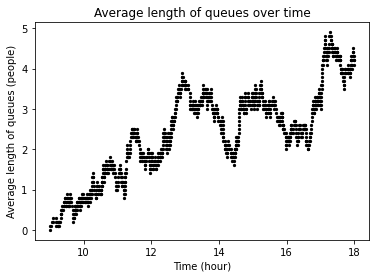

In [20]:
#We run 1 instance to prove that the code works
arrival = 60 #go by the hour: 1 customer per min so 60 customers per hour 
#convert all these parameters into hours
service = 3/60
service_variance = 1/60
manager = 4/60
manager_variance = 1/60
duration = 18
service_time_variance = 1/60
queue_num = 9
grocery_store = run_simulation(arrival, service, service_variance, manager, manager_variance, duration, queue_num)

In [21]:
#define a run_simulation function that does not return grocery store but return the average waiting time
def run_simulation2(arrival_rate, service_rate, service_time_variance, 
                    manager_rate, manager_time_variance, run_until, nqueue):
    schedule = Schedule()
    grocery_store = GroceryStore(
        arrival_rate, service_rate, service_time_variance, manager_rate, manager_time_variance, nqueue)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    list_waiting_time=[]
    for i in grocery_store.list_of_queue:
        for j in range(len(i.list_departure_time)-1):
            list_waiting_time.append(i.list_departure_time[j]-i.list_arrival_time[j])
    avg_waiting_time = np.mean(list_waiting_time)*60 #in terms of minutes
    return np.mean(list_waiting_time)*60 #return average waiting time

In [22]:
%%capture 
#disable all print statements
arrival = 60
service = 3/60
service_variance = 1/60
manager = 4/60
manager_variance = 1/60
duration = 18
service_time_variance = 1/60
list_avg_waiting_time=[[],[],[],[],[],[],[],[],[],[]] #list of 10 blank lists
for i in range(1,11): #try with different number of queues
    for j in range(100): #run 100 trials
        list_avg_waiting_time[i-1].append(
            run_simulation2(arrival, service, service_variance, manager, manager_variance, duration, i))


95% confidence interval for 1 queue(s) is [186.79, 190.9] minutes
95% confidence interval for 2 queue(s) is [183.75, 187.1] minutes
95% confidence interval for 3 queue(s) is [166.11, 169.89] minutes
95% confidence interval for 4 queue(s) is [144.85, 148.39] minutes
95% confidence interval for 5 queue(s) is [120.27, 124.23] minutes
95% confidence interval for 6 queue(s) is [95.41, 100.44] minutes
95% confidence interval for 7 queue(s) is [70.65, 74.58] minutes
95% confidence interval for 8 queue(s) is [46.1, 50.77] minutes
95% confidence interval for 9 queue(s) is [27.13, 30.16] minutes
95% confidence interval for 10 queue(s) is [19.47, 20.7] minutes


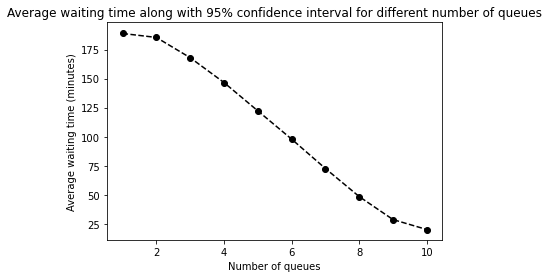

In [23]:
#calculate expected value and 95% confidence interval of average waiting time 
x=np.arange(1,11)
expected_avg_waiting_time = []
waiting_error = []
for i in list_avg_waiting_time:
    expected_avg_waiting_time.append(np.mean(i))
    std_error_waiting_time = sts.sem(i)
    print("95% confidence interval for", list_avg_waiting_time.index(i)+1, "queue(s) is", 
         [round(np.mean(i) - 1.96*std_error_waiting_time,2),round(np.mean(i) + 1.96*std_error_waiting_time,2)], "minutes")
    waiting_error.append(std_error_waiting_time)
plt.figure()
plt.errorbar(x, expected_avg_waiting_time, waiting_error, color="black", marker='o', linestyle='--')
plt.title("Average waiting time along with 95% confidence interval for different number of queues")
plt.xlabel("Number of queues")
plt.ylabel("Average waiting time (minutes)")
plt.show()

We see in the above graph (and the ones below as well) that the confidence intervals are small compared to the actual data points (since we have 100 trials our certainty is high). Therefore, they are barely visible in the error plot. Therefore, I have made a series of print statements to clarify the confidence intervals.

In [9]:
#define a run_simulation function that does not return grocery store but return the max queue length
def run_simulation3(arrival_rate, service_rate, service_time_variance, 
                    manager_rate, manager_time_variance, run_until, nqueue):
    schedule = Schedule()
    grocery_store = GroceryStore(
        arrival_rate, service_rate, service_time_variance, manager_rate, manager_time_variance, nqueue)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    max_queue_length=0
    for i in grocery_store.list_of_queue:
        if i.max_queue_length > max_queue_length:
            max_queue_length = i.max_queue_length
    return max_queue_length

In [10]:
%%capture 
#disable all print statements
arrival = 60
service = 3/60
service_variance = 1/60
manager = 4/60
manager_variance = 1/60
duration = 18
service_time_variance = 1/60
list_max_queue_length=[[],[],[],[],[],[],[],[],[],[]] #list of 10 blank lists
for i in range(1,11):
    for j in range(100):
        list_max_queue_length[i-1].append(
            run_simulation3(arrival, service, service_variance, manager, manager_variance, duration, i))


95% confidence interval for 1 queue(s) is [476.38, 486.3] customers
95% confidence interval for 2 queue(s) is [209.76, 214.24] customers
95% confidence interval for 3 queue(s) is [119.98, 123.4] customers
95% confidence interval for 4 queue(s) is [75.14, 77.48] customers
95% confidence interval for 5 queue(s) is [48.92, 50.74] customers
95% confidence interval for 6 queue(s) is [30.4, 32.02] customers
95% confidence interval for 7 queue(s) is [18.85, 19.97] customers
95% confidence interval for 8 queue(s) is [10.01, 11.21] customers
95% confidence interval for 9 queue(s) is [4.52, 5.18] customers
95% confidence interval for 10 queue(s) is [2.66, 2.94] customers


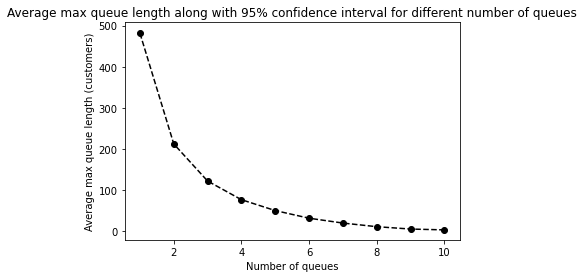

In [11]:
#calculate expected value and 95% confidence interval of max queue length 
x=np.arange(1,11)
expected_max_queue_length = []
max_queue_error = []
for i in list_max_queue_length:
    expected_max_queue_length.append(np.mean(i))
    std_error_max_queue_length = sts.sem(i)
    print("95% confidence interval for", list_max_queue_length.index(i)+1, "queue(s) is", 
         [round(np.mean(i) - 1.96*std_error_max_queue_length,2),
          round(np.mean(i) + 1.96*std_error_max_queue_length,2)], "customers")
    max_queue_error.append(std_error_max_queue_length)
plt.figure()
plt.errorbar(x, expected_max_queue_length, max_queue_error, color="black", marker='o', linestyle='--')
plt.title("Average max queue length along with 95% confidence interval for different number of queues")
plt.xlabel("Number of queues")
plt.ylabel("Average max queue length (customers)")
plt.show()

### Proposed third quantity: average queue length throughout the day

Details and explanation to be provided in the report.

In [12]:
#define a run_simulation function that does not return grocery store but return the average queue length
def run_simulation4(arrival_rate, service_rate, service_time_variance, 
                    manager_rate, manager_time_variance, run_until, nqueue):
    schedule = Schedule()
    grocery_store = GroceryStore(
        arrival_rate, service_rate, service_time_variance, manager_rate, manager_time_variance, nqueue)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    list_queue_length=[]
    for i in grocery_store.list_of_queue:
        for j in range(len(i.list_arrival_time)-1):
            list_queue_length.append(i.people_in_queue)
    avg_queue_length = np.mean(list_queue_length) 
    return avg_queue_length

In [13]:
%%capture 
#disable all print statements
arrival = 60
service = 3/60
service_variance = 1/60
manager = 4/60
manager_variance = 1/60
duration = 18
service_time_variance = 1/60
list_avg_queue_length=[[],[],[],[],[],[],[],[],[],[]] #list of 10 blank lists
for i in range(1,11):
    for j in range(100):
        list_avg_queue_length[i-1].append(
            run_simulation4(arrival, service, service_variance, manager, manager_variance, duration, i))

95% confidence interval for 1 queue(s) is [454.68, 463.52] customers
95% confidence interval for 2 queue(s) is [199.21, 203.33] customers
95% confidence interval for 3 queue(s) is [114.65, 117.93] customers
95% confidence interval for 4 queue(s) is [72.65, 75.04] customers
95% confidence interval for 5 queue(s) is [45.09, 46.94] customers
95% confidence interval for 6 queue(s) is [29.63, 31.1] customers
95% confidence interval for 7 queue(s) is [17.7, 19.08] customers
95% confidence interval for 8 queue(s) is [8.46, 9.68] customers
95% confidence interval for 9 queue(s) is [2.72, 3.54] customers
95% confidence interval for 10 queue(s) is [1.19, 1.57] customers


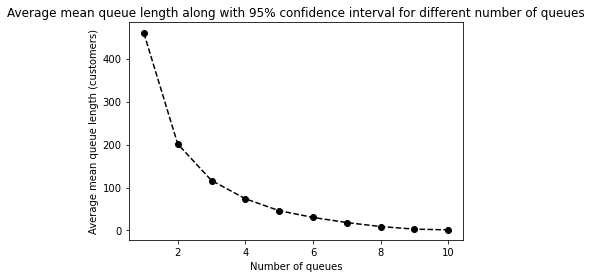

In [14]:
#calculate expected value and 95% confidence interval of average queue length
x=np.arange(1,11)
expected_avg_queue_length = []
avg_queue_error = []
for i in list_avg_queue_length:
    expected_avg_queue_length.append(np.mean(i))
    std_error_avg_queue_length = sts.sem(i)
    print("95% confidence interval for", list_avg_queue_length.index(i)+1, "queue(s) is", 
         [round(np.mean(i) - 1.96*std_error_avg_queue_length,2),
          round(np.mean(i) + 1.96*std_error_avg_queue_length,2)], "customers")
    avg_queue_error.append(std_error_avg_queue_length)
plt.figure()
plt.errorbar(x, expected_avg_queue_length, avg_queue_error, color="black", marker='o', linestyle='--')
plt.title("Average mean queue length along with 95% confidence interval for different number of queues")
plt.xlabel("Number of queues")
plt.ylabel("Average mean queue length (customers)")
plt.show()